In [ ]:
#setup
import numpy as np
import matplotlib.pyplot as plt
from GrafTo.run import Grafting
import json
import subprocess
import os

# set path for putting files of new system

ROOT = os.getcwd() 
FOLDER = f"{ROOT}/MONO" 

# setting plotting parameters
plt.rcParams.update({"font.size": 12,"text.usetex": False,"mathtext.fontset": "stixsans"}) 

COLORS = {"water,K0":"xkcd:cornflower", "water,K1":"xkcd:algae green", "water,K2":"xkcd:raspberry", "water,K5":"xkcd:amber",
          "vacuum,K0":"xkcd:cornflower", "vacuum,K1":"xkcd:algae green", "vacuum,K2":"xkcd:raspberry", "vacuum,K5":"xkcd:amber",
          "toluene,K0":"xkcd:cornflower", "toluene,K1":"xkcd:algae green", "toluene,K2":"xkcd:raspberry", "toluene,K5":"xkcd:amber"}

MARKERS = {"water":"o", "vacuum":"s"}


Creating fcc lattice
Dimensions: 20.047172182805397 20.102627813458138 2.014411934947645
a:0.7460784944250537, d1:0.5275571627054052, d2:0.2637785813527026, d3:0.45687790485132135

Creating fcc lattice
Dimensions: 20.047172182805397 20.102627813458138 2.014411934947645
a:0.7460784944250537, d1:0.5275571627054052, d2:0.2637785813527026, d3:0.45687790485132135


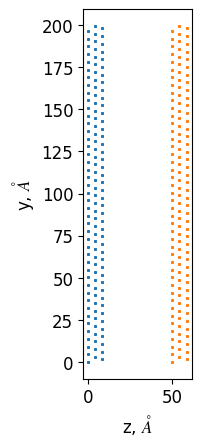

In [2]:
# Example to create a flat slab of 20x20x3 nm^3 to make piston

NewSystem = Grafting.NewSystem(root=FOLDER)
NewSystem.build_slab(outName=f"piston1.gro", atomNames=["PIS1","N1P"], Ns= [ 20, 20, 2 ], a=0.47*2**(1/6))
u = NewSystem.universe
pos1 = u.atoms.positions

NewSystem = Grafting.NewSystem(root=FOLDER)
NewSystem.build_slab(outName=f"piston2.gro", atomNames=["PIS2","N1P"], Ns= [ 20, 20, 2 ], a=0.47*2**(1/6))
u = NewSystem.universe
pos2 = u.atoms.positions

plt.scatter(pos1[:,2], pos1[:,1], s=0.1)
plt.scatter(pos2[:,2]+50, pos2[:,1], s=0.1)
plt.xlabel("z, $\AA$")
plt.ylabel("y, $\AA$")
plt.gca().set_aspect('equal')



Creating fcc lattice
Dimensions: 20.047172182805397 20.102627813458138 20.14411934947645
a:0.7460784944250537, d1:0.5275571627054052, d2:0.2637785813527026, d3:0.45687790485132135


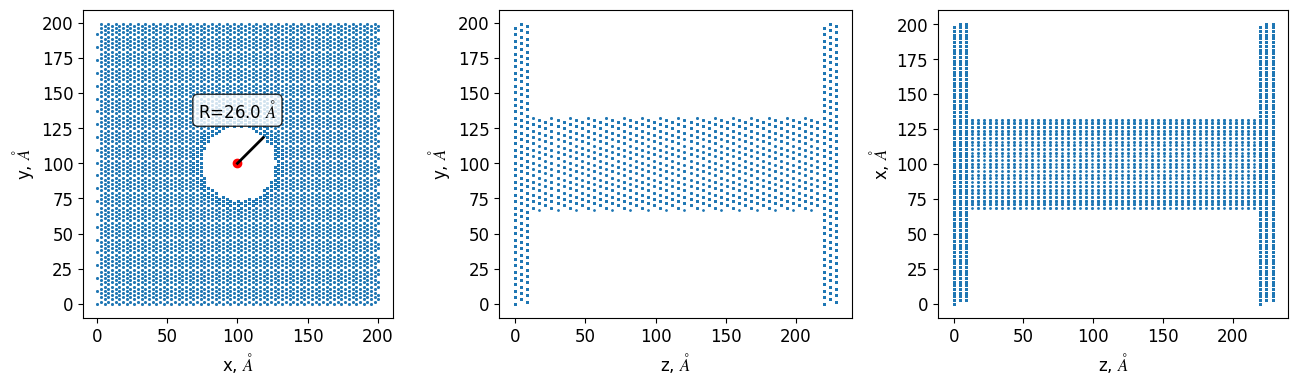

In [3]:
# Example to create a cylindrical surface (pore with radius of 2.6 nm in a block matrix of 20x20x20 nm^3)

NewSystem = Grafting.NewSystem(root=FOLDER)
NewSystem.build_slab(outName=f"block.gro", atomNames=["BULK","N1B"], Ns=[ 20, 20, 20 ], a=0.47*2**(1/6))

center, radius = [10,10], 2.6
NewSystem.make_cylindrical_pore(out_name="modified.gro", center=center, radius=radius, atomNames=["BULK","N1B"])
u = NewSystem.universe

pos = u.atoms.positions

fig, ax = plt.subplots(1,3, figsize=(16,4))
ax[0].scatter(pos[:,0], pos[:,1], s=1, alpha=1)
ax[0].set_xlabel("x, $\AA$")
ax[0].set_ylabel("y, $\AA$")
ax[0].scatter(center[0]*10, center[1]*10, c="red")
ax[0].plot([center[0]*10 ,center[0]*10+radius*10*np.cos(45*np.pi/180)], [center[1]*10, center[1]*10+radius*10*np.sin(45*np.pi/180)], ls="solid", lw=2, c="k", marker="none")
ax[0].set_aspect('equal')
ax[0].annotate(f"R={radius*10} $\AA$", np.array(center)*10+(0,30), ha="center", va="bottom", bbox=dict(facecolor='white', edgecolor='k', boxstyle='round', alpha=0.8))

ax[1].scatter(pos[:,2], pos[:,1], s=1, alpha=1)
ax[1].set_xlabel("z, $\AA$")
ax[1].set_ylabel("y, $\AA$")
ax[1].set_aspect('equal')

ax[2].scatter(pos[:,2], pos[:,0], s=1, alpha=1)
ax[2].set_xlabel("z, $\AA$")
ax[2].set_ylabel("x, $\AA$")
ax[2].set_aspect('equal')


In [4]:
#make input file

# Used for polydisperse cases
PDI = { "K0":1.3, "K1":1.3, "K2":1.3, "K5":1.35}
N = { "K0":15, "K1":72, "K2":88, "K5":308 }

# Used for monodisperse case
MOL_SIZE = 4

# If monodisperse, set 'monodisperse' to MOL_SIZE and 'polydisperse' to False
# If polydisperse, set 'polydisperse' to [PDI, N] and set 'monodisperse' to False

GRAFT_DENSITY, SAMPLE_NAME = 0.3, "MONO"
print(FOLDER)

data = {
    "folder": FOLDER,
    "surface_distance": 0.5,  # distance between chain beads, in nm
    "grafting_density": GRAFT_DENSITY,  # grafting density
    "perturbation":0, # intensity to perturbate atom positions randomly
    "name": SAMPLE_NAME,
    "matrix":
    {
        "file": f"{FOLDER}/modified.gro",  # path to matrix you wish to graft
        "size": False, #[ 50, 10, 9 ]  # if 'file' is set to False and [lx,ly,lz] is given to 'size', creates a flat slab with lx x ly x lz nm^3 dimensions
    },

    "grafting method":
    {
        "to": False,  # code is ready but not implemented, attaches pre built molecules to the surface
        "from": True  # grows from the surface
    },

    "chain dispersity":
    {
        "monodisperse": MOL_SIZE,
        "polydisperse": False # [ float(PDI[SAMPLE]) , int(N[SAMPLE]) ] for polydisperse
    },

    "atom names": {
        "polymer": ["SIL","C1"], # ["PDMS","DMS"] for PDMS
        "bulk":[ "BULK","N1B" ], 
        "layer":[ "LAY","N1L" ], 
        "under_polymer":[ "SIL","N1L1" ]  # ["PDMS", "N1L1"] for PDMS
    },

    "surface geometry": 
    {
        "cylindrical": True,
        "flat": False
    }
}

# save options to input file
with open(f'{ROOT}/Grafter/input_grafter.json', 'w', encoding='utf-8') as f:
        json.dump(data, f, ensure_ascii=False, indent=4)

# if work folder doesn't exist, make one
subprocess.run(f"mkdir -p {FOLDER};",
               shell=True, executable="/bin/bash")

print("Input file created.")

/Users/frasera/Ricerca/scripts/MONO
Input file created.



name: MONO
folder: /Users/frasera/Ricerca/scripts/MONO
surface distance: 0.5 nm
grafting density: 0.3 gps/nm^3
matrix: ['file', '/Users/frasera/Ricerca/scripts/MONO/modified.gro']
dispersity: ['mono', 4]
surface geometry: cylindrical
atom names: {'polymer': ['SIL', 'C1'], 'bulk': ['BULK', 'N1B'], 'layer': ['LAY', 'N1L'], 'under_polymer': ['SIL', 'N1L1']}
tilt molecule: 0


Using chain size 4
Adding molecules: 100.00%   
Number of molecules: 130  -  Number of spots: 2608  -  Max. grafting dens.: 6.016



/Users/frasera/Ricerca/scripts/Grafter/run/Grafting.py:292: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_mol = pd.concat([df_mol,self.dfs["polymer"].iloc[k:kk]],axis=0,ignore_index=True)


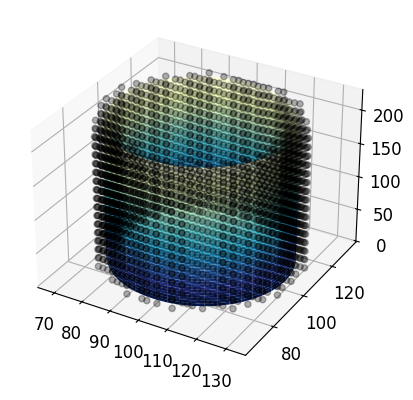

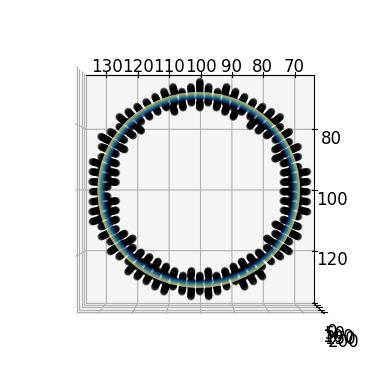

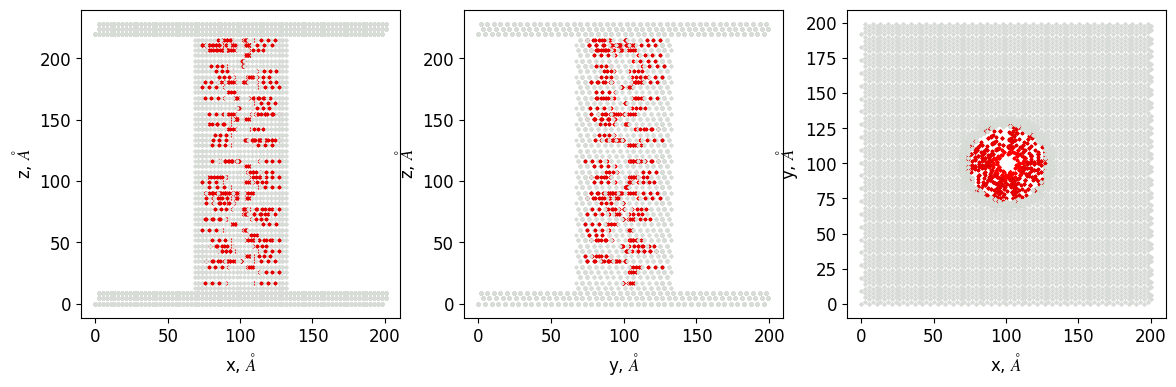

In [5]:
# build system using input file information
NewSystem = Grafting.NewSystem(root=f"{ROOT}")   # instantiate new system class and set the working directory
NewSystem.read_inputs_grafter(f'{ROOT}/Grafter/input_grafter.json')  # read input parameters
NewSystem.graft_matrix()  # graft matrix with parameters from input
NewSystem.out_gro(fname="initial_config.gro") # save the final configuration to a .gro file

# Plot system to check
NewSystem.plot_system(colors={"END":"red","C1":"xkcd:red","N1L":"xkcd:light gray","N1L1":"xkcd:light gray","N1B":"xkcd:light gray"})
print(" ")

In [6]:
# Input for assembling system with pistons

data = {
    "folder": f"{FOLDER}",
    "blocks": [
        "piston1.gro",
        "initial_config.gro",
        "piston2.gro"
    ],
    "positions": [
        [0,0,100],
        [0,0,100+2+220],
        [0,0,100+2*2+220*2+200]
    ],
    "box dimensions": [
        200.4700, 197.9800, 100+2*2+220*2+200+100,90,90,90
    ],
    "transforms": False,
    "name": "MONO",
    "out name": "assembled.gro"
}

# save options to input file
with open(f'{ROOT}/Grafter/input_assembler.json', 'w', encoding='utf-8') as f:
        json.dump(data, f, ensure_ascii=False, indent=4)

print("Input file created.")

Input file created.



name: MONO
root: /Users/frasera/Ricerca/scripts/MONO
blocks: ['piston1.gro', 'initial_config.gro', 'piston2.gro']
positions: [[  0   0 100]
 [  0   0 322]
 [  0   0 744]]
box: [200.47, 197.98, 844, 90, 90, 90]
transformations: [None, None, None]
out name: assembled.gro


.*.*.*.*.*.*.*.*.*.*.*.
Starting assembling

name:  MONO 
root:  None 
blocks:  ['piston1.gro', 'initial_config.gro', 'piston2.gro'] 
positions:  [[  0   0 100]
 [  0   0 322]
 [  0   0 744]] 
box:  [200.47, 197.98, 844, 90, 90, 90] 
transformations:  [None, None, None] 
out name:  assembled.gro 

Finished assembling (:
.*.*.*.*.*.*.*.*.*.*.*.


File 'lay-sil.itp' generated successfully.
 


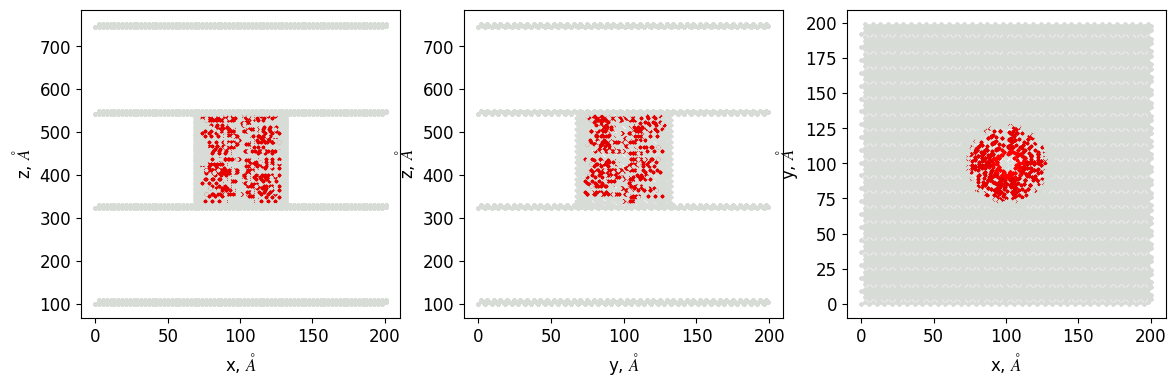

In [7]:
# Read input file and run assembler

NewSystem.read_inputs_assembler(f'{ROOT}/Grafter/input_assembler.json')
NewSystem.run_assembler()

# data to build the topology files for GROMACS

s1 =[{"atom": "END", "res": "SIL", "type": "C2", "charge": 0.0, "mass": 72.0}]
s2 = [ {"atom": "C1", "res": "SIL", "type": "C1", "charge": 0.0, "mass": 72.0} for i in range(MOL_SIZE-1)] 
s3 = [{"atom": "N1L1", "res": "LAY", "type": "N1L1", "charge": 0.0, "mass": 72.0}]
sil_atoms = s1 + s2 + s3

bulk_atom = {"name": "BULK", "atom": "N1B", "res": "BULK", "type": "N1B", "charge": 0.0, "mass": 72.0}
lay_atom = {"name": "LAY", "atom": "N1L", "res": "LAY", "type": "N1L", "charge": 0.0, "mass": 72.0}
pis1_atom = {"name": "PIS1", "atom": "N1P", "res": "PIS1", "type": "N1P", "charge": 0.0, "mass": 72.0}
pis2_atom =  {"name": "PIS", "atom": "N1P", "res": "PIS2", "type": "N1P", "charge": 0.0, "mass": 72.0}

# Constructing the molecules list
molecules = [
    {
        "name": f"SIL{MOL_SIZE}",
        "atoms": sil_atoms,
        "bonds": [{"id1": i, "id2": i + 1, "funct": 1} for i in range(1, len(sil_atoms))],
        "angles": [{"i": i, "j": i + 1, "k": i + 2, "funct": 2} for i in range(1, len(sil_atoms) - 2)]
    },
    {
        "name": "LAY",
        "atoms": [lay_atom],
    },
    {
        "name": "BULK",
        "atoms": [bulk_atom],
    },
    {
        "name": "PIS1",
        "atoms": [pis1_atom],
    },
    {
        "name": "PIS2",
        "atoms": [pis2_atom],
    }
]

# Generate .itp file
NewSystem.make_itp_sil(molecules=molecules, out_name="lay-sil.itp")

# Generate .top file
includes = ['#include "martini_v3.0.0_N1Lay.itp"', 
            '#include "itps/martini_v3.0.0_solvents_v1.itp"', 
            '#include "lay1-sil.itp"', '#include "itps/surf.itp"',
            '#include "itps/martini_v3.0.0_small_molecules_v1.itp"']

NewSystem.out_topology(fname="initial_config.gro", includes=includes, out_name="topol.top")

# Plot system to check
NewSystem.plot_system(colors={"END":"red","C1":"xkcd:red","N1L":"xkcd:light gray","N1L1":"xkcd:light gray","N1B":"xkcd:light gray","N1P":"xkcd:light gray"})
print(" ")

<Axes: xlabel='N', ylabel='Count'>

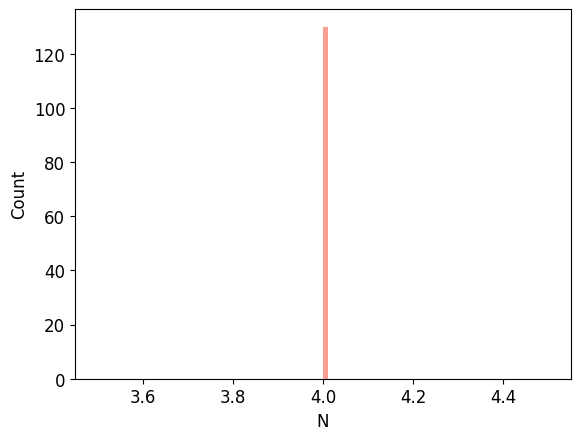

In [8]:
NewSystem.plot_mol_distribution() # plot distribution of chain sizes